# ERP + LSTM + P300 

Here we gonna demonstrate basic process on working on EEG signals.  For the sake of simplicity, we shall work on a fairly simple P300 dataset.

We shall also visit event-related potentials and long short-term memory for decoding the signals.

Note:  We assume you are quite familiar with neural network so we will mostly just use it without too much cluttered explanation.

## Import basic libaries

In [1]:
import mne
from mne import create_info
from mne.io import RawArray

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, WeightedRandomSampler

In [2]:
#in case you want to set more configs...
# print(mne.get_config(key=''))

In [3]:
#this will set the plotting size
mne.set_config('MNE_BROWSE_RAW_SIZE','10,5')  

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Loading the data

In [5]:
df = pd.read_csv("../data/p300-6trials-12rep-chaky.csv")

In [6]:
df.head()

,timestamps,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,55102.712,43787.426,36719.758,19511.619,47260.172,38144.504,36332.605,24059.730,19694.703,0
1,55102.712,43780.832,36711.020,19499.572,47253.020,38134.625,36320.555,24050.947,19682.455,0
2,55102.713,43788.094,36718.016,19503.305,47263.008,38141.910,36326.344,24061.363,19692.646,0
3,55102.713,43778.371,36705.117,19489.291,47253.285,38129.258,36311.707,24055.416,19674.988,0
4,55102.714,43778.484,36702.750,19484.619,47249.172,38125.461,36304.148,24050.566,19666.764,0


In [7]:
#we don't need timestamps for modeling
df = df.drop(["timestamps"], axis=1)

In [8]:
df.columns = ['P4', 'Pz', 'P3', 'PO4', 'POz', 'PO3', 'O2', 'O1', 'Marker']   #channels named according to how we plug our eeg device
df.head()

,P4,Pz,P3,PO4,POz,PO3,O2,O1,Marker
0,43787.426,36719.758,19511.619,47260.172,38144.504,36332.605,24059.730,19694.703,0
1,43780.832,36711.020,19499.572,47253.020,38134.625,36320.555,24050.947,19682.455,0
2,43788.094,36718.016,19503.305,47263.008,38141.910,36326.344,24061.363,19692.646,0
3,43778.371,36705.117,19489.291,47253.285,38129.258,36311.707,24055.416,19674.988,0
4,43778.484,36702.750,19484.619,47249.172,38125.461,36304.148,24050.566,19666.764,0


Let's look at how the marker was generated.  Here is the format:

- 0:  nothing happens
- 1:  flash on non-target
- 2:  flash on target

In [9]:
print(df['Marker'].unique())

[0 1 2]


**Some background**:
    
In case you are lost about the data, first, you need to understand EEG experiment.

In EEG-like experiment, you usually have a session. (1 record)

The data you usually have is in a form of (channels, samples)

For instance, if you record EEG with 16 channels, sample rate of 128 Hz, and 5 seconds long then you would end up with a session in a shape of (16, 128 x 5), since 1 second will have 128 samples, i.e., by definition.

One addition channel we record is `marker`.

A `marker` is sort of mapper during the record to later identify when does something happen.

A data with 3 EEG chanels + marker will might look like this

```
[
 .
 .
 .
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 1], <----- Some event1, like flashes or images happen here:
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 2], <----- Some event2 again but another target happen here:
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 .
 .
 .
]
```
Thus, we are interested to retrieve all samples after the event is shown for a period of time (maybe 3s after event1 is shown), this process is called `epoching`.

## 2. Transform Data into Raw MNE object

First we gonna use Python MNE as it provides many useful methods for achieving these tasks.  So first, we gonna transform our pandas to mne type.  Here is the function transforming df to raw mne.

Transform df to raw mne.

Creating RawArray with float64 data, n_channels=9, n_times=53328
    Range : 0 ... 53327 =      0.000 ...   426.616 secs
Ready.
Effective window size : 2.048 (s)


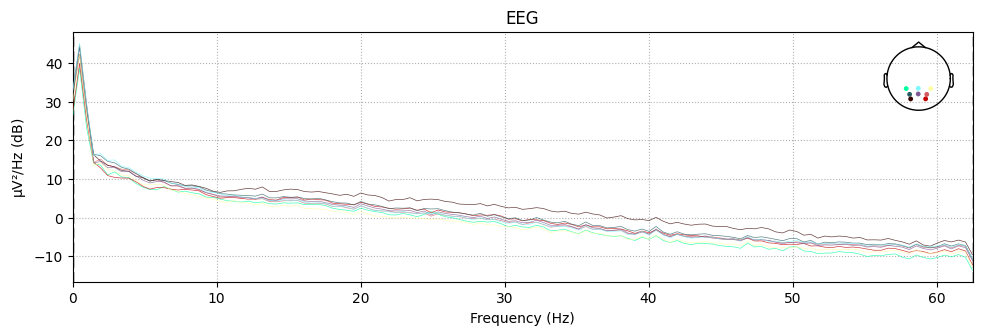

In [11]:
raw = df_to_raw(df)

Here is some short summary regarding mne data structures:

https://mne.tools/stable/most_used_classes.html

1. MNE.io.Raw
  - The `MNE.io.Raw` is you entire session. In this class, you can perform a preprocess for the entire session like `filter`
2. MNE.Epochs
  - The Epochs is an idea for segment the entire session to smaller windows. You can epoching you session in any how you like. The most common epoching is follow the `marker/event` channel
3. MNE.Evoked
  - Evoked is a data that you obtain from each epochs. 

You can think of the Epochs is an Array of Evoked.

## 3. Artifact Removal

Artifacts are noises that need to be removed. Two examples of frequency-restricted artifacts are slow drifts and power line noise. Here we illustrate how each of these can be repaired by filtering.

But first we gonna use Python MNE as it provides many useful methods for achieving these tasks.  So first, we gonna transform our pandas to mne type.  Here is the function transforming df to raw mne.

In [10]:
def df_to_raw(df):
    sfreq = 125  #our OpenBCI headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.compute_psd().plot()

    return raw

#### 1. Power line noise

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 62.5Hz (125Hz / 2 according to Nyquist Theorem), we don't need to run the harmonics but simply notch the 50Hz signal.

In [12]:
raw.notch_filter(50) #250/2 based on Nyquist Theorem

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 825 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


<RawArray | 9 x 53328 (426.6 s), ~3.7 MB, data loaded>

Effective window size : 2.048 (s)


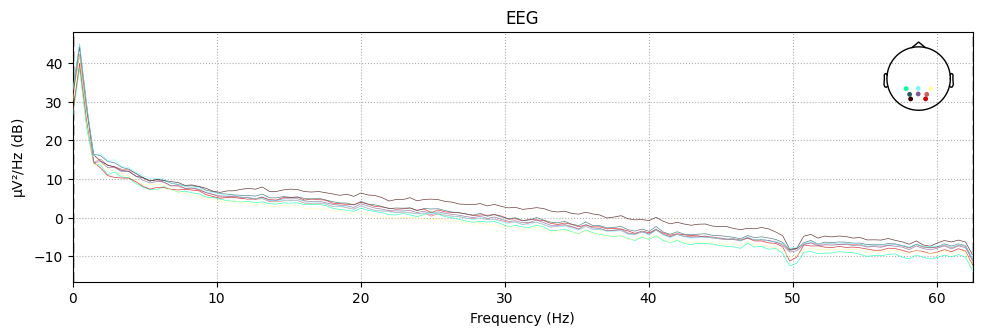

In [13]:
#observe that the 50Hz noise is now gone, yay!
raw.compute_psd().plot()

#### 2. Slow drift

Low-frequency drifts usually lies below 1Hz.  In addition, since for P300, it is safe to assume that no useful data is beyond 40Hz.  

In [14]:
raw.filter(1, 40)
raw.compute_psd().plot();

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (3.304 sec)

Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


## 4. Epoching

Epoching is a process of extracting only the relevant EEG data when the event happens.  Here we shall extract -0.1 seconds before the event starts until 0.6 seconds after the event starts.  Here we choose 0.6 seconds because we knew P300 happens around 300ms so it's a good middle.

In [15]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [16]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'Non-Target': 1, 'Target' : 2}
tmin = -0.1
tmax = 0.6
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)

720 events found
Event IDs: [1 2]
sample drop %:  0.0


## 4. EDA

### Plotting ERP of targets vs. non-targets

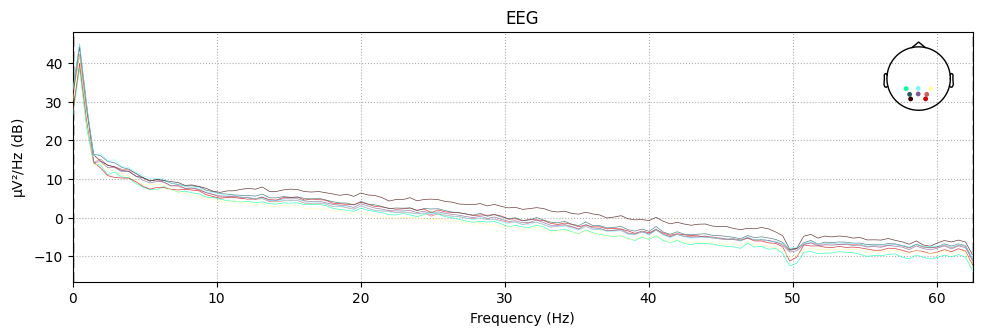

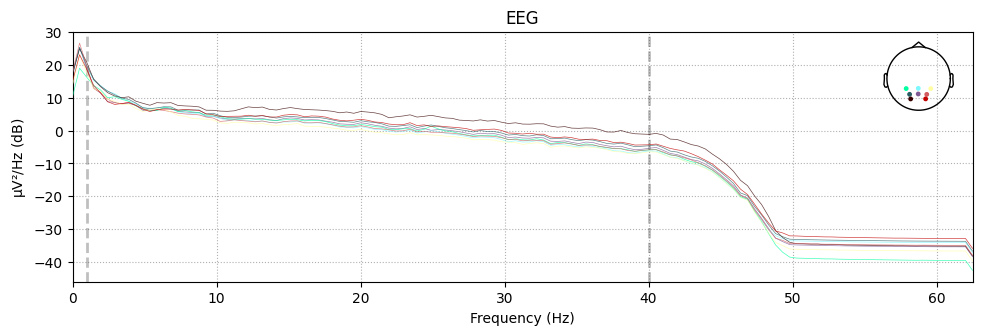

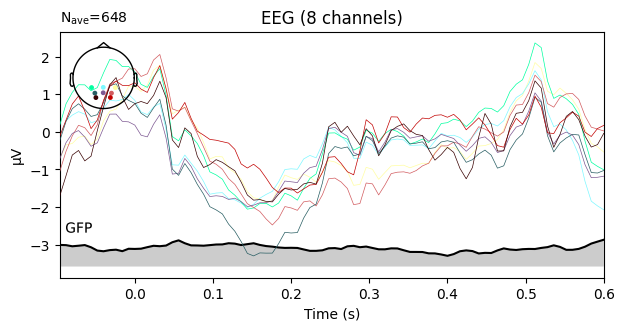

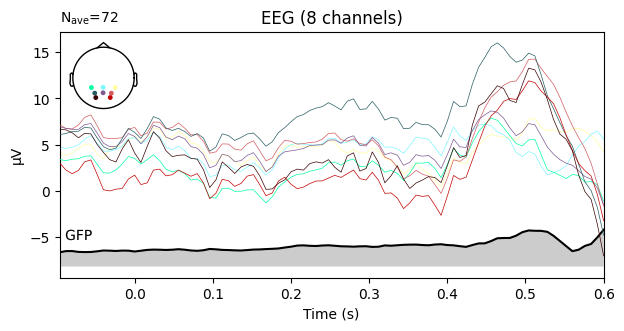

In [17]:
evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s');
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s');

### Plotting scalp topographies

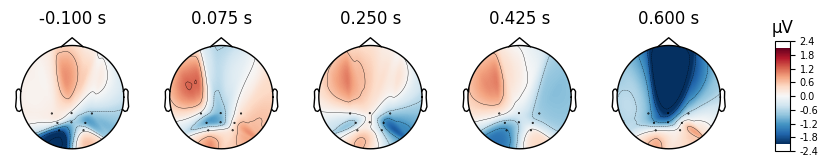

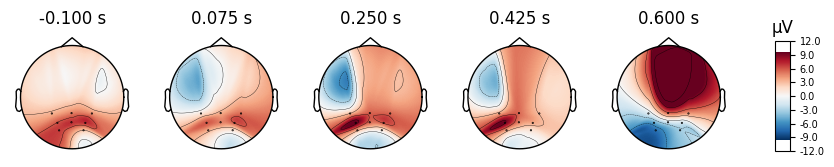

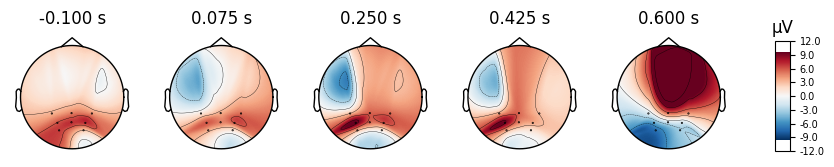

In [18]:
times = np.linspace(-0.1, 0.6, 5)
evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
evoked_target.plot_topomap(ch_type='eeg', times=times, colorbar=True)

### Plotting ERP and topographies

No projector specified for this dataset. Please consider the method self.add_proj.


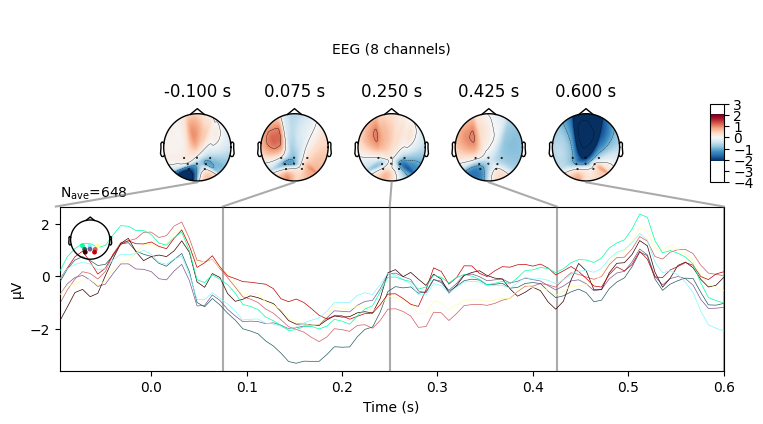

No projector specified for this dataset. Please consider the method self.add_proj.


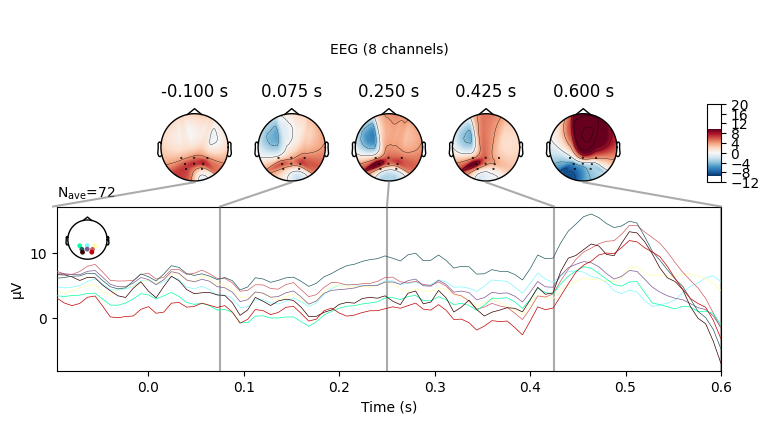

In [19]:
evoked_non.plot_joint(times=times);
evoked_target.plot_joint(times=times);

### Comparing Evoked objects

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


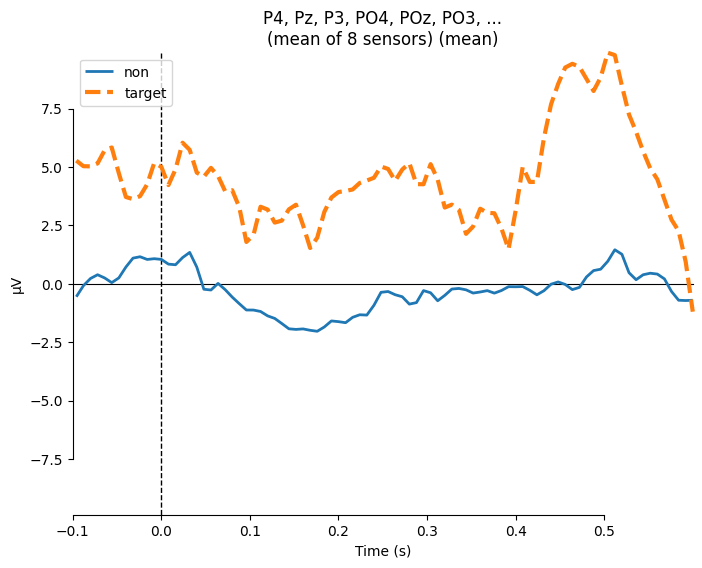

[<Figure size 800x600 with 1 Axes>]

In [51]:
def custom_func(x):
    return x.max(axis=1)

total_evoked = {"non": evoked_non, "target": evoked_target}
# for combine in ('mean', 'median', 'gfp', custom_func):
mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine='mean',
                             colors=dict(non=0, target=1),
                             linestyles=dict(non='solid', target='dashed'),
                             styles=dict(non=dict(linewidth=2),target=dict(linewidth=3))) 

## 6. Feature Extraction

Let's get our X and y in numpy form. Here X should have shape of `(batch, channels, length)` and y should have shape of `(batch)`.

For calculate of samples, since we get 0.6 seconds after + 0.1 seconds before, and our sampling rate is 125, thus the total sample is 0.7 * 125 = 88 (rounded up).

In [21]:
X = epochs.get_data()
y = epochs.events[:, -1]

print(X.shape)
print(y.shape)
print(type(X))

(720, 8, 88)
(720,)
<class 'numpy.ndarray'>


In [22]:
X[0].shape

(8, 88)

In [23]:
y[0]

1

Splitting

In [24]:
train_size = 504
val_size   = 144
test_size   = 72

#use our numpy indexing technique
X_train   = X[:train_size]
X_val     = X[train_size:val_size+train_size]
X_test    = X[-test_size:]

y_train   = y[:train_size]
y_val     = y[train_size:val_size+train_size]
y_test    = y[-test_size:]

Rearrange the array to `(batch_size, length, channel)` for pyTorch `nn.LSTM`

In [25]:
X_train = np.transpose(X_train, (0, 2, 1))
X_val   = np.transpose(X_val, (0, 2, 1))
X_test  = np.transpose(X_test, (0, 2, 1))

In [26]:
X_train.shape, X_val.shape, X_test.shape

((504, 88, 8), (144, 88, 8), (72, 88, 8))

**Important**:  We need to do some scaling, since EEG values are either very small or very big.  If not, the training won't go well due to vanishing/exploding gradients.  Minmax normalization is a common tool for applying on signals.

In [27]:
from sklearn.preprocessing import MinMaxScaler

#scale transform each channel independently
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_val.shape[2]):
    X_val[:, :, i]   = scalers[i].transform(X_val[:, :, i])     
    
for i in range(X_test.shape[2]):
    X_test[:, :, i]  = scalers[i].transform(X_test[:, :, i]) 

In [28]:
print(X_train.mean(), X_val.mean(), X_test.mean())
print(X_train.min(), X_val.min(), X_test.min())
print(X_train.max(), X_val.max(), X_test.max())

0.05815916434289996 0.0595045318971445 0.05556356673758584
-1.0 -1.6481434185101311 -1.466568865555225
1.0000000000000004 1.591086485349625 1.386629769486391


Convert to torch tensor for pyTorch

In [29]:
X_train = torch.FloatTensor(X_train)
X_val   = torch.FloatTensor(X_val)
X_test  = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train) - 1 #minus 1 so it becomes 0 or 1
y_val   = torch.LongTensor(y_val)   - 1 #minus 1 so it becomes 0 or 1
y_test  = torch.LongTensor(y_test)  - 1 #minus 1 so it becomes 0 or 1

Let's check the distribution of the class, to see whether there is class imbalance

In [30]:
print(len(y_train[y_train == 0]), len(y_train[y_train == 1]))
print(len(y_val[y_val == 0]),     len(y_val[y_val == 1]))
print(len(y_test[y_test == 0]),   len(y_test[y_test == 1]))

453 51
131 13
64 8


**Important**: Let's utilize the `Dataset` and `WeightRandomSampler` since our class is hugely imbalanced.  What we can do is to force every batch to have the same amount of each class.

The idea is to assign bigger weight to minority class, thus penaltizing if it is wrong.

In [31]:
labels_unique, counts = np.unique(y, return_counts=True)
labels_unique, counts

(array([1, 2]), array([648,  72]))

In [32]:
class_weights = [sum(counts) / c for c in counts]
class_weights

[1.1111111111111112, 10.0]

Now we are ready to create the `WeightRandomSampler`

In [33]:
sample_weights_train = [class_weights[i] for i in y_train]
sample_weights_val   = [class_weights[i] for i in y_val  ]
sample_weights_test  = [class_weights[i] for i in y_test ]

sample_weights_train[:10]

[1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 10.0,
 1.1111111111111112]

In [34]:
train_sampler = WeightedRandomSampler(sample_weights_train, len(y_train), replacement=True)
val_sampler   = WeightedRandomSampler(sample_weights_val,   len(y_val),   replacement=True)
test_sampler  = WeightedRandomSampler(sample_weights_test,  len(y_test),  replacement=True)

In [35]:
# Define dataset
ds_train = TensorDataset(X_train, y_train)
ds_val   = TensorDataset(X_val, y_val)
ds_test  = TensorDataset(X_test, y_test)

In [36]:
BATCH_SIZE = 10 

#Train set loader
train_loader = torch.utils.data.DataLoader(dataset=ds_train, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = train_sampler)
#Validation set loader
val_loader = torch.utils.data.DataLoader(dataset=ds_val, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = val_sampler)

#Test set loader
test_loader = torch.utils.data.DataLoader(dataset=ds_test, 
                                          batch_size=BATCH_SIZE, 
                                          sampler = test_sampler)

## 6.1 Testing how train loader works

In [37]:
torch.set_printoptions(sci_mode=False)
for X_train, y_train in train_loader:
    print(torch.mean(X_train, axis=[1,2]))
    print(y_train)
    break

tensor([0.5116, 0.0512, 0.0587, 0.1917, 0.0525, 0.1677, 0.3073, 0.0630, 0.0605,
        0.2339])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])


## 7. Models

In [38]:
class eegLSTM(nn.Module):
    def __init__(self, input_size = 8, hidden_size=50, out_size=2):
        super().__init__()
        self.lstm   = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
    def forward(self, seq):
        #seq shape: (10, 88, 8)
        out, (_, _) = self.lstm(seq)
        #out shape: (N, L, Hout * D) ==> (10, 88, 50)
        out = out[:, -1, :] #(B, Hout)
        # out = torch.mean(out, axis=1)  #you can also try meaning the hidden states
        #out shape: (10, 50)
        out = self.linear(out)
        #out shape: (10, 2)
        return out
        

In [39]:
model = eegLSTM().to(device)

## 7.1 Optional:  Illustrating each step

In [40]:
fake_eeg_data = torch.randn((10, 88, 8)) #(batch_size, length, features/channels)

In [41]:
lstm   = nn.LSTM(8, 50, batch_first=True)

In [42]:
out, _ = lstm(fake_eeg_data)
out.shape

torch.Size([10, 88, 50])

In [43]:
out = out[:, -1, :]  #last hidden state
out.shape

torch.Size([10, 50])

In [44]:
linear = nn.Linear(50, 2)

In [45]:
out = linear(out)
out.shape

torch.Size([10, 2])

## 8. Training

In [46]:
torch.manual_seed(999999)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [47]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [48]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 1600?, why 10000????

  1600
 10000
   200
   200
   100
     2
______
 12102


In [49]:
epochs = 20

best_valid_loss = float('inf')
model.train()

#print(f"Training {type(model).__name__}")

for i in range(epochs):
    train_total = 0
    train_correct = 0
    val_total   = 0  
    val_correct = 0
    train_acc   = 0
    val_acc     = 0
    
    for X_train, y_train in train_loader:
    
        start_time = time.time()
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        yhat_train = model(X_train)
        
        #train acc
        _, predicted = torch.max(yhat_train.data, 1)  #returns max value, indices
        train_total += y_train.size(0)  #keep track of total
        train_correct += (predicted == y_train).sum().item()  #.item() give the raw number
        train_acc = 100 * (train_correct / train_total)
        
        train_loss = criterion(yhat_train, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        end_time = time.time()

        #val accuracy
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            yhat_val  = model(X_val)
            val_loss     = criterion(yhat_val, y_val)
            _, predicted = torch.max(yhat_val.data, 1)  #returns max value, indices
            val_total += y_val.size(0)  #keep track of total
            val_correct += (predicted == y_val).sum().item()  #.item() give the raw number
            val_acc = 100 * (val_correct / val_total)

        #save the best model
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            #print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), '../models/p300LSTM.pth.tar')
            best_model_index = i

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {i:2.0f} | Train acc: {train_acc: 2.2f} | " +
          f"loss: {train_loss:2.2f} | Val acc: {val_acc: 2.2f} | " +
          f"loss: {val_loss:2.2f} | Time: {epoch_mins}m {epoch_secs}s")

Epoch:  0 | Train acc:  52.78 | loss: 0.69 | Val acc:  50.83 | loss: 0.66 | Time: 0m 0s
Epoch:  1 | Train acc:  54.76 | loss: 0.71 | Val acc:  52.41 | loss: 0.63 | Time: 0m 0s
Epoch:  2 | Train acc:  61.51 | loss: 0.55 | Val acc:  56.36 | loss: 1.21 | Time: 0m 0s
Epoch:  3 | Train acc:  55.95 | loss: 0.58 | Val acc:  59.76 | loss: 0.58 | Time: 0m 0s
Epoch:  4 | Train acc:  60.91 | loss: 0.56 | Val acc:  53.08 | loss: 1.08 | Time: 0m 0s
Epoch:  5 | Train acc:  76.19 | loss: 0.17 | Val acc:  68.14 | loss: 0.69 | Time: 0m 0s
Epoch:  6 | Train acc:  76.39 | loss: 0.17 | Val acc:  67.92 | loss: 0.83 | Time: 0m 0s
Epoch:  7 | Train acc:  82.74 | loss: 0.12 | Val acc:  76.87 | loss: 0.14 | Time: 0m 0s
Epoch:  8 | Train acc:  94.64 | loss: 0.06 | Val acc:  86.60 | loss: 0.18 | Time: 0m 0s
Epoch:  9 | Train acc:  90.08 | loss: 0.20 | Val acc:  86.19 | loss: 0.12 | Time: 0m 0s
Epoch: 10 | Train acc:  92.86 | loss: 0.25 | Val acc:  88.85 | loss: 0.05 | Time: 0m 0s
Epoch: 11 | Train acc:  92.46 | 

So our train accs and val accs are very close, indicating a very good learning process that can be generalized.

## 9. Inference / Testing

In [50]:
model = eegLSTM().to(device)
model.load_state_dict(torch.load('../models/p300LSTM.pth.tar'))

model.eval()

with torch.no_grad():
    total   = 0
    correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        predictions   = model(X_test)
        test_loss     = criterion(predictions, y_test)
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
    
print(f"Accuracy: {acc:2.3f}")

Accuracy: 98.611


Note: For production, you have to normalize the incoming signals first.

In this next tutorial, let's try `conv1d.`